# Gradient and Climate Velocity Plots (Omega Aragonite)

## 1950s Omega Aragonite (fix to match temp)

In [1]:
import xgcm
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [2]:
%matplotlib inline

In [3]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

## Surface k01

In [4]:
# k01 temperaturefor ensemble average (preprocessed)
directory = '~/chazbpei2020/data/processed/Omega_Arag/'
filename = 'omega_arag_k01_ensAvg_1950_2100.nc'
oa_path = directory+filename
ds = xr.open_dataset(oa_path).rename({'XT_OCEAN': 'xt_ocean',
                                     'YT_OCEAN': 'yt_ocean',
                                     'TIME': 'time',
                                     'OMEGA_ARAG': 'omega_arag'})

## Grid calculations

In [5]:
# default behavior is to extrapolite grid position to the left
ds_full = xgcm.generate_grid_ds(ds, {'X':'xt_ocean', 'Y':'yt_ocean'})

In [6]:
# Create grid object (periodic along X-axis)
grid = xgcm.Grid(ds_full, periodic=['X'], 
                 coords={'X': {'center': 'xt_ocean', 'left': 'xt_ocean_left'},
                         'Y': {'center': 'yt_ocean', 'left': 'yt_ocean_left'},
                         'T': {'center': 'time'}})

In [7]:
# Compute cartesian distances
grid_calculations(grid, ds_full)

In [8]:
# Calculate the decadal mean omega aragonite for the 1950s
ds_oa_annual = ds_full.omega_arag.groupby('time.year').mean(dim='time', skipna=True)
ds_oa_mean = ds_oa_annual.sel(year=1950).copy()
for yr in range(1951,1960):
     ds_oa_mean += ds_oa_annual.sel(year=yr)
        
ds_oa_mean = ds_oa_mean/10

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/common.py:671: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  return self._groupby_cls(
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [9]:
# ds_oa_mean.plot()

## Zonal Gradient of k01 Omega Aragonite (Omega / km)

In [10]:
# Compute zonal (along x-axis) gradient of k01 Omega Aragonite
doa_dx = grid.diff(ds_oa_mean, 'X', boundary='fill', fill_value=np.nan) / (ds_full.dxg / 1000)
doa_dx = doa_dx.squeeze()

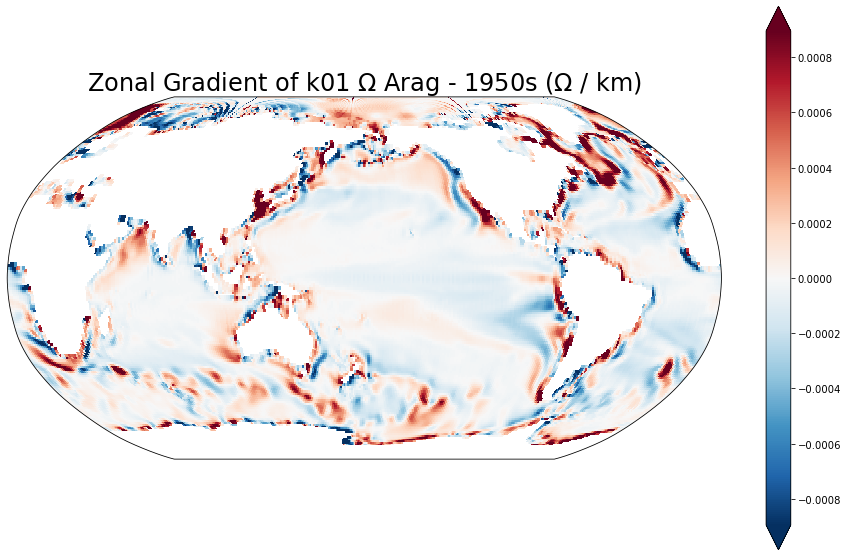

In [18]:
# Plot mean zonal Omega Aragonite gradient in 1950s
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

doa_dx.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)

ax.set_title('Zonal Gradient of k01 $\Omega$ Arag - 1950s ($\Omega$ / km)',
             fontsize=24)
ax.set_global()

fig.savefig("oa_vel_plots")

## Meridional Gradient of k01 Omega Arag (Omega / km)

In [38]:
# Compute meridional (along y-axis) gradient of k01 Omega Aragonite
doa_dy = grid.diff(ds_oa_mean, 'Y', boundary='fill', fill_value=np.nan) / (ds_full.dyg / 1000)
doa_dy = doa_dy.squeeze()

In [41]:
# Flip direction in southern hemisphere so directions are poleward
doa_dy[0:90] = -doa_dy[0:90]

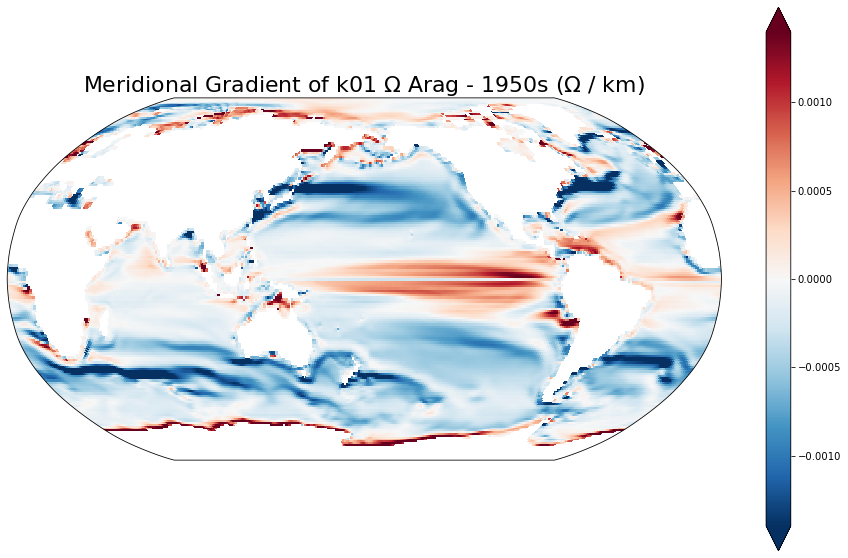

In [42]:
# Plot mean meridional Omega Aragonite gradient in 1950s
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

doa_dy.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)

ax.set_title('Meridional Gradient of k01 $\Omega$ Arag - 1950s ($\Omega$ / km)',
             fontsize=22)
ax.set_global() 
fig.savefig("oa_vel_plots")

## Gradient Magnitude of k01 Omega Aragonite (Omega / km)

In [22]:
# Calculate magnitude of spatial gradient
dx2 = np.square(doa_dx).data
dy2 = np.square(doa_dy).data
doa_ds = np.sqrt(dx2+dy2)
# Create DataArray
lon = ds_full.xt_ocean.data
lat = ds_full.yt_ocean.data
doa_ds = xr.DataArray(doa_ds, dims=['yt_ocean','xt_ocean'], coords=[lat,lon])

In [16]:
# Create meshgrid for arrow plotting
X,Y = np.meshgrid(np.arange(360), np.arange(-90,90))
X = X+0.5
Y = Y+0.5
n=5

### Normalized Arrows

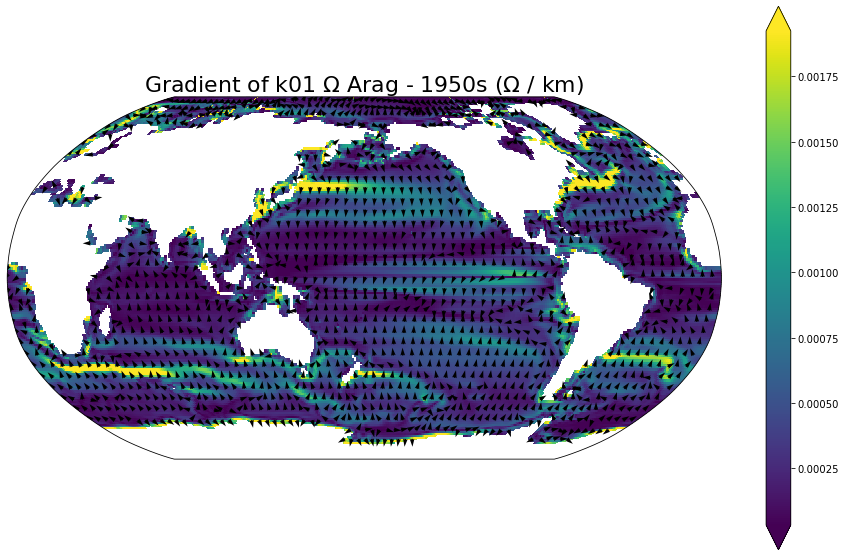

In [24]:
# Plot mean Temperature gradient in 1950s
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

src=ccrs.PlateCarree()
doa_ds.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)

ax.set_title('Gradient of k01 $\Omega$ Arag - 1950s ($\Omega$ / km)',
             fontsize=22)

# Normalize vectors to plot arrows of constant size
U = doa_dx.data
V = doa_dy.data
N = np.sqrt(U**2 + V**2)
U = U/N
V = V/N

# Plot arrows to show gradient direction
ax.quiver(X[::n,::n], Y[::n,::n], U[::n,::n], V[::n,::n],
           transform=src)
ax.set_global()
fig.savefig("oa_vel_plots")

### Contour Plot

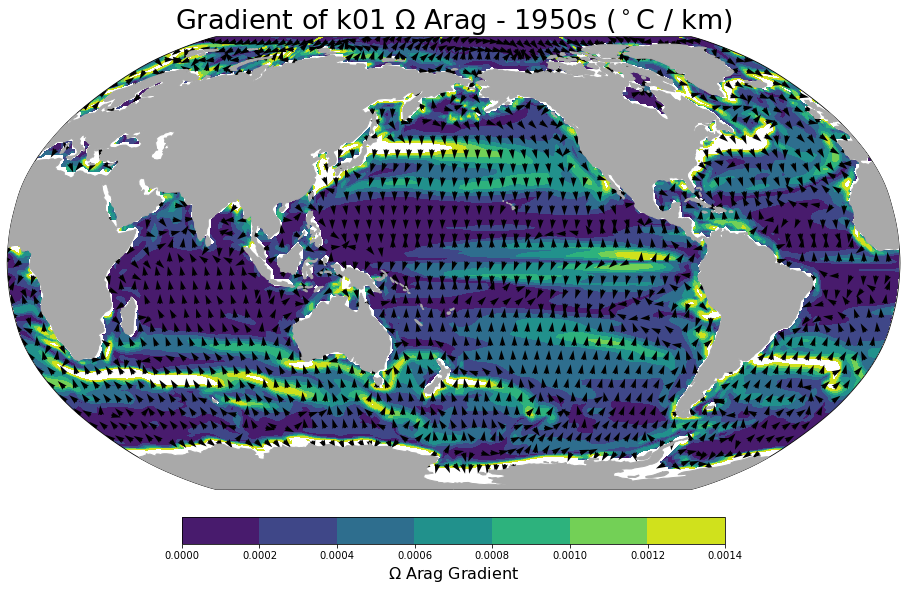

In [32]:
# Plot mean Omega Arag gradient in 1950s -- Contour Plot
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

src = ccrs.PlateCarree()
levels = np.arange(0,0.0016,0.0002)
im = ax.contourf(lon,lat,doa_ds, levels=levels,
                 transform=src, robust=True)
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('$\Omega$ Arag Gradient', fontsize=16)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')

ax.set_title('Gradient of k01 $\Omega$ Arag - 1950s ($^\circ$C / km)',
             fontsize=27)

# Normalize vectors to plot arrows of constant size
U = doa_dx.data
V = doa_dy.data
N = np.sqrt(U**2 + V**2)
U = U/N
V = V/N

# Plot arrows to show gradient direction
ax.quiver(X[::n,::n], Y[::n,::n], U[::n,::n], V[::n,::n],
           transform=src)

ax.set_global()
fig.savefig("oa_vel_plots")

## k01 Omega Arag Change

### Annual Omega Arag Change in 1950s

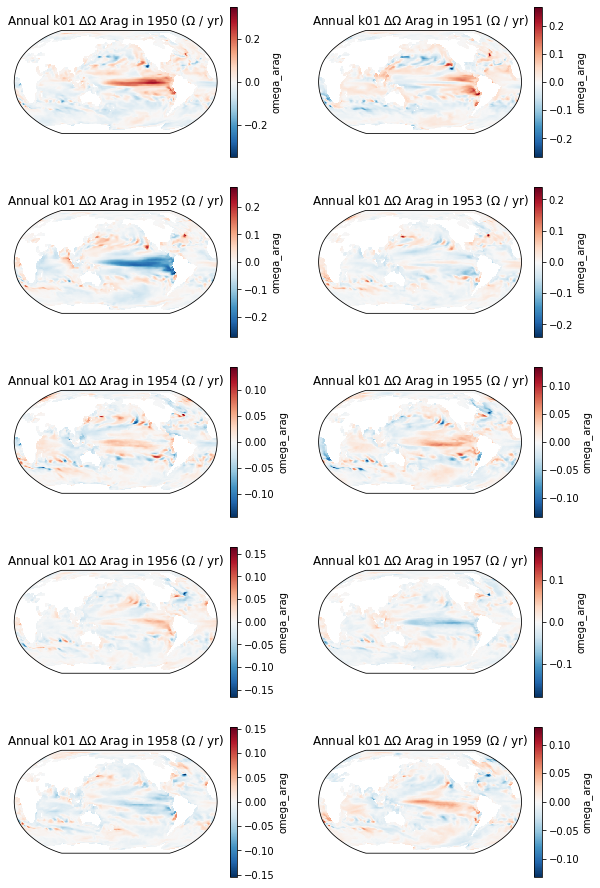

In [14]:
# Plot annual Omega Aragonite change during 1950s
crs = ccrs.Robinson(central_longitude=180)
nrows = 5
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[10,16],
                               subplot_kw={'projection':crs})

# Calculate doa/dt for each year
time0 = 1950
time1 = 1951
for row in range(0,nrows):
    for col in range(0,ncols):

        ax = axs[row,col]
        doa_dt = (ds_oa_annual.sel(year=time1) - ds_oa_annual.sel(year=time0))
        doa_dt.plot(ax=ax, transform=ccrs.PlateCarree(), robust=False)

        ax.set_title('Annual k01 $\Delta$$\Omega$ Arag in '+str(time0)+' ($\Omega$ / yr)')
        ax.set_global()
        time0 += 1 # increment years
        time1 += 1
        
fig.savefig("oa_vel_plots")

### Decadal Temperature Change in 1950s (ºC / decade)

#### Using Linear Regression (best model)

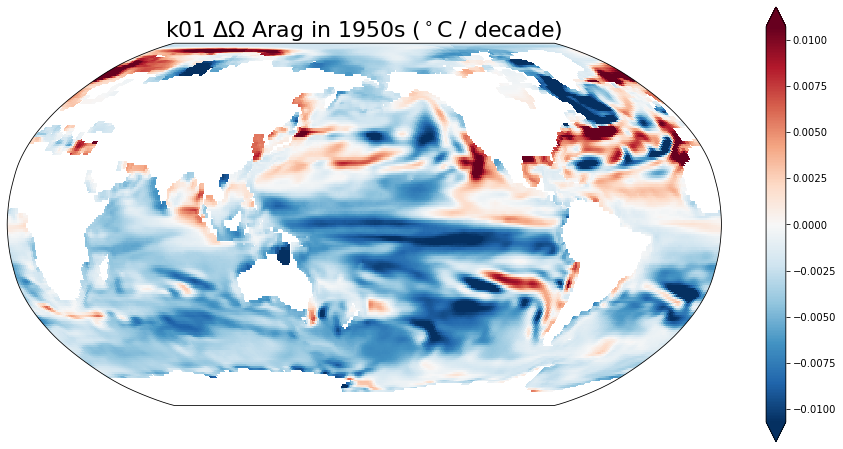

In [75]:
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,8],
                               subplot_kw={'projection':crs})

# Get annual omega arag data for 1950s
ds_decade = ds_oa_annual.loc[1950:1959]

# Get lon, lat and time values
lon = ds_decade.xt_ocean.data
lat = ds_decade.yt_ocean.data
years = ds_decade.year

# For each gridcell, obtain the linear regression for temperature
# change using the annual means over the decade
nx = len(lon)
ny = len(lat)
da_bestfit = np.zeros(shape=(nx,ny))
for x in range(nx):
    for y in range(ny):
        # exclude NaN values
        cell = ds_decade.sel(xt_ocean=lon[x], yt_ocean=lat[y])
        idx = np.isfinite(cell).data.squeeze()
        # calculate linear regression for omega aragonite (Y) vs. year (X)
        # (if there are at least 2 finite values)
        if sum(idx) > 1:
            da_bestfit[x,y] = np.polyfit(years[idx], cell[idx], 1)[0]
        else:
            da_bestfit[x,y] = np.nan
            
            
# Create DataArray and plot doa/dt for the decade
doa_dt = xr.DataArray(da_bestfit, dims=['xt_ocean','yt_ocean'], coords=[lon,lat])

levels = np.arange(-0.012,0.013,0.002)
doa_dt.T.plot(ax=ax, levelstransform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 $\Delta$$\Omega$ Arag in 1950s ($^\circ$C / decade)', 
             fontsize=22)
ax.set_global()
fig.savefig("oa_vel_plots")

## Zonal Omega Aragonite Velocity (km/decade)

<ipython-input-76-9b932a0033cb>:11: RuntimeWarning: divide by zero encountered in true_divide
  x_vel = dOA_dt/dOA_dx


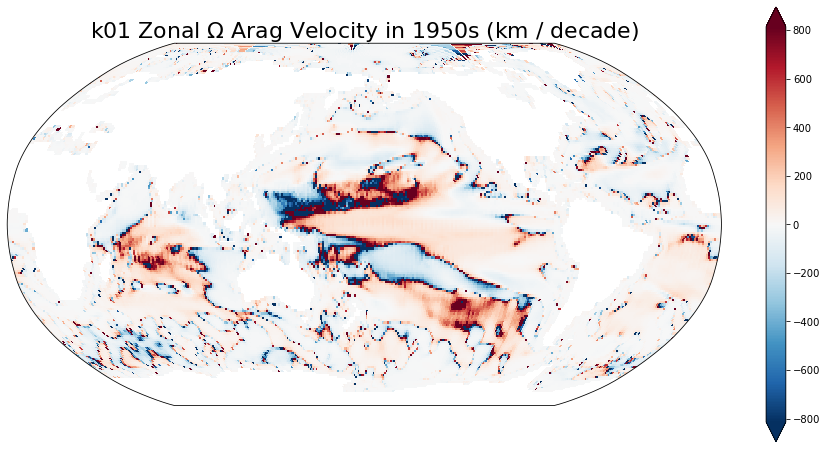

In [76]:
# Plot zonal omega arag velocity (km/decade) for 1950s
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,8],
                               subplot_kw={'projection':crs})

# Using linear regression over decade for Omega Arag change over time,
# and time-mean decadal Omega Arag for spatial gradient
dOA_dt = doa_dt.squeeze().data
dOA_dx = doa_dx.squeeze().T.data

x_vel = dOA_dt/dOA_dx

# Create DataArray and plot Omega Arag velocity
x_vel = xr.DataArray(x_vel, dims=['xt_ocean', 'yt_ocean'], coords=[lon,lat]).T
x_vel = x_vel.where(x_velocity.loc[:,:] < np.inf)

x_vel.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 Zonal $\Omega$ Arag Velocity in 1950s (km / decade)',
             fontsize=22)

fig.savefig("oa_vel_plots")

## Meridional Omega Aragonite Velocity (km/decade)

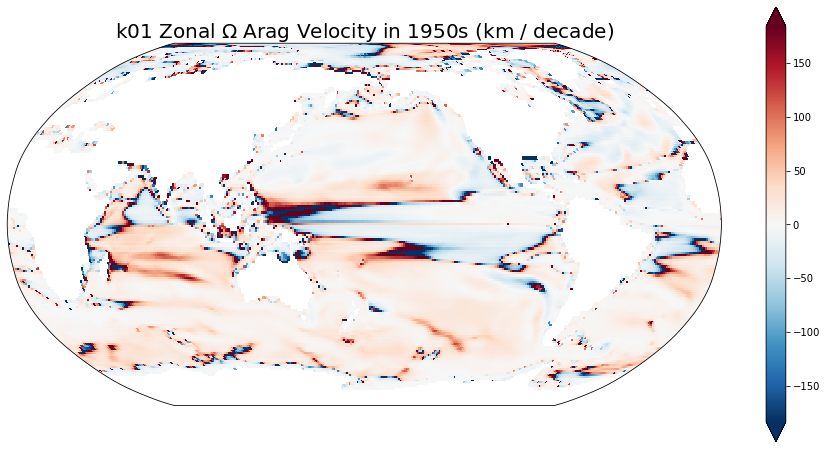

In [77]:
# Plot meridional omega arag velocity (km/decade) for 1950s
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,8],
                               subplot_kw={'projection':crs})

# Using linear regression over decade for Omega Arag change over time,
# and time-mean decadal Omega Arag for spatial gradient
dOA_dt = doa_dt.squeeze().data
dOA_dy = doa_dy.squeeze().T.data
y_vel = dOA_dt/dOA_dy

# Create DataArray and plot Omega Arag velocity
y_vel = xr.DataArray(y_vel, dims=['xt_ocean', 'yt_ocean'], coords=[lon,lat]).T
y_vel = y_vel.where(y_velocity.loc[:,:] != np.inf)

y_vel.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 Zonal $\Omega$ Arag Velocity in 1950s (km / decade)',
             fontsize=20)

fig.savefig("oa_vel_plots")

## Omega Arag Velocity (km/decade)

In [78]:
# Calculate the magnitude for Omega Arag velocity 
vx2 = np.square(x_vel).data
vy2 = np.square(y_vel).data
velocity = np.sqrt(vx2+vy2)
# Create DataArray
lon = ds_full.xt_ocean.data
lat = ds_full.yt_ocean.data

velocity = xr.DataArray(velocity, dims=['yt_ocean','xt_ocean'], coords=[lat,lon])
velocity = velocity.where(velocity.loc[:,:] != np.inf)

### Normalized Arrows

<ipython-input-79-4ee323a343ae>:16: RuntimeWarning: invalid value encountered in true_divide
  U = U/N
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


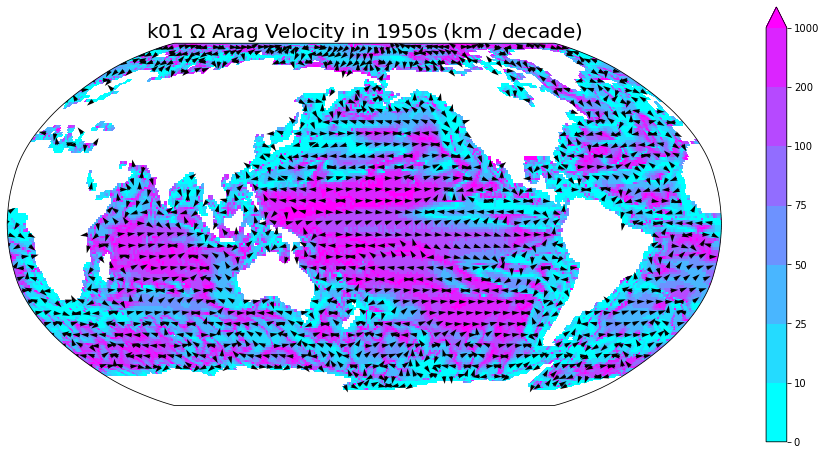

In [79]:
# Plot omega arag velocity magnitude (km/decade) for 1950s
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,8],
                               subplot_kw={'projection':crs})

# Create DataArray and plot temperature velocity
levels = [0,10,25,50,75,100,200,1000]
velocity.plot(ax=ax, levels=levels, transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 $\Omega$ Arag Velocity in 1950s (km / decade)',
             fontsize=20)

# Normalize vectors to plot arrows of constant size
U = x_vel.data
V = y_vel.data
N = np.sqrt(U**2 + V**2)
U = U/N
V = V/N
n=5

# Plot arrows to show gradient direction
ax.quiver(X[::n,::n], Y[::n,::n], U[::n,::n], V[::n,::n],
           transform=src)

fig.savefig("oa_vel_plots")

---